In [1]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


In [2]:
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [3]:
!pip install -q xgboost

In [4]:
!pip install -q lightgbm

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, RandomizedSearchCV,GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict,KFold
from sklearn.metrics import accuracy_score, precision_score,make_scorer, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings("ignore", message="Dask dataframe query planning is disabled because dask-expr is not installed.")


In [6]:
train = pd.read_csv('/content/train_go.csv')
test = pd.read_csv('/content/test_go.csv')
submission = pd.read_csv('/content/SampleSubmission.csv')

In [8]:
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

In [9]:
train.shape,test.shape,submission.shape

((68654, 80), (18594, 80), (18594, 2))

In [10]:
train.head()

,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,...,day_due_freq,day_of_week_due_freq,lender_id_bin_freq,f_min,f_max,f_mean,f_sd,f_median,f_sum,f_skew
0,3,0,8448.0,8448.0,7,1,120.85,0.014305,121.0,0.0,...,0.031829,0.139831,0.904021,0.000000,8448.0,2830.225401,4183.547350,120.85,25472.028610,0.856889
1,3,0,25895.0,25979.0,7,1,7768.50,0.300000,7794.0,0.0,...,0.031829,0.189231,0.904021,0.003244,25979.0,9507.844805,11076.628154,7768.50,85570.603244,0.717019
2,1,21,6900.0,7142.0,7,1,1380.00,0.200000,1428.0,0.0,...,0.024448,0.154892,0.095979,0.035072,7142.0,2486.381675,3110.332631,1380.00,22377.435072,0.806076
3,3,0,8958.0,9233.0,7,1,2687.40,0.300000,2770.0,0.0,...,0.034878,0.146548,0.904021,0.030699,9233.0,3325.181189,3876.178464,2687.40,29926.630699,0.726403
4,3,0,4564.0,4728.0,7,1,1369.20,0.300000,1418.0,0.0,...,0.044093,0.193024,0.904021,0.035933,4728.0,1697.959548,1978.910976,1369.20,15281.635933,0.728793


In [11]:
test.head()

,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,...,day_due_freq,day_of_week_due_freq,lender_id_bin_freq,f_min,f_max,f_mean,f_sd,f_median,f_sum,f_skew
0,3,0,1919.0,1989.0,7,1,575.7,0.300000,597.0,NaN,...,0.048013,0.161723,0.904021,0.036477,1989.0,714.626275,831.775897,575.700000,6431.636477,0.729619
1,3,0,2138.0,2153.0,7,1,0.0,0.000000,0.0,NaN,...,0.033468,0.161723,0.904021,0.000000,2153.0,715.111891,1070.927218,0.007016,6436.007016,0.857189
2,3,0,8254.0,8304.0,7,1,207.0,0.025079,208.0,NaN,...,0.018625,0.161723,0.904021,0.006058,8304.0,2780.784024,4067.100701,207.000000,25027.056215,0.856582
3,3,0,3379.0,3379.0,7,1,1013.7,0.300000,1014.0,NaN,...,0.041101,0.139831,0.904021,0.000000,3379.0,1239.844444,1442.689794,1013.700000,11158.600000,0.716730
4,3,0,120.0,120.0,7,1,36.0,0.300000,36.0,NaN,...,0.036918,0.146548,0.904021,0.000000,120.0,44.844444,50.495003,36.000000,403.600000,0.732116


In [12]:
submission.head()

,ID,target
0,ID_269404226088267278,0
1,ID_255356300042267278,0
2,ID_257026243764267278,0
3,ID_264617299409267278,0
4,ID_247613296713267278,0


In [13]:
train.shape,test.shape,submission.shape

((68654, 80), (18594, 80), (18594, 2))

In [14]:
train.columns

Index(['lender_id', 'loan_type', 'Total_Amount', 'Total_Amount_to_Repay',
       'duration', 'New_versus_Repeat', 'Amount_Funded_By_Lender',
       'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'target',
       'total_amount_bins', 'Total_Amount_log', 'interestFees',
       'interestFees_bins', 'Amount_Funded_By_Lender_log',
       'Lender_portion_Funded_bins', 'Lender_portion_to_be_repaid_log',
       'loan_type_bins', 'year_dis', 'month_dis', 'quarter_dis', 'day_dis',
       'day_of_week_dis', 'year_due', 'month_due', 'quarter_due', 'day_due',
       'day_of_week_due', 'lender_id_bin', 'Interest_Burden', 'Debt_rate',
       'Funding_Gap', 'prod_fees_burden_funding_gap',
       'add_fees_burden_funding_gap', 'duration_interestfees',
       'duration_total_amount', 'duration_lender_funded', 'lender_id_count',
       'loan_type_count', 'loan_type_bins_count', 'New_versus_Repeat_count',
       'total_amount_bins_count', 'interestFees_bins_count',
       'Lender_portion_Funded_b

In [16]:
test.columns

Index(['lender_id', 'loan_type', 'Total_Amount', 'Total_Amount_to_Repay',
       'duration', 'New_versus_Repeat', 'Amount_Funded_By_Lender',
       'Lender_portion_Funded', 'Lender_portion_to_be_repaid',
       'total_amount_bins', 'Total_Amount_log', 'interestFees',
       'interestFees_bins', 'Amount_Funded_By_Lender_log',
       'Lender_portion_Funded_bins', 'Lender_portion_to_be_repaid_log',
       'loan_type_bins', 'year_dis', 'month_dis', 'quarter_dis', 'day_dis',
       'day_of_week_dis', 'year_due', 'month_due', 'quarter_due', 'day_due',
       'day_of_week_due', 'lender_id_bin', 'Interest_Burden', 'Debt_rate',
       'Funding_Gap', 'prod_fees_burden_funding_gap',
       'add_fees_burden_funding_gap', 'duration_interestfees',
       'duration_total_amount', 'duration_lender_funded', 'lender_id_count',
       'loan_type_count', 'loan_type_bins_count', 'New_versus_Repeat_count',
       'total_amount_bins_count', 'interestFees_bins_count',
       'Lender_portion_Funded_bins_count'

In [15]:
test = test.drop('target',axis=1)

In [17]:
#Changing the Claim target from int to object through mapping
train['target'] = train['target'].map({0: 0, 1: 1})

In [18]:
#negative
train.corr()['target'].sort_values()[train.corr()['target'].sort_values() < 0]

,target
interestFees_bins_freq,-0.323216
interestFees_bins,-0.323216
interestFees_bins_count,-0.323216
loan_type_count,-0.221421
loan_type_freq,-0.221421
loan_type_bins_count,-0.220256
loan_type_bins,-0.220256
loan_type_bins_freq,-0.220256
lender_id_count,-0.188266
lender_id_freq,-0.188266


In [19]:
#positive
train.corr()['target'].sort_values()[train.corr()['target'].sort_values() > 0]

,target
day_of_week_due,0.011209
f_min,0.013564
duration_interestfees,0.030861
prod_fees_burden_funding_gap,0.037760
Debt_rate,0.045418
Lender_portion_Funded,0.045418
duration_total_amount,0.051027
duration_lender_funded,0.064233
Total_Amount_log,0.074828
Amount_Funded_By_Lender_log,0.077766


In [20]:
X = train.drop('target', axis=1)
y = train['target']
print(X.shape)
print(y.shape)

(68654, 79)
(68654,)


In [21]:
y.value_counts()

,count
target,
0,67396
1,1258


- Highly imbalanced dataset sampling in this case might introduce bias we will go with class weights

# Modelling
Given the nature of our dataset our focus will be on the F1 score and note the accuracy

In [22]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define models
models = {
    # "Logistic Regression": LogisticRegression(),
    "Catboost": CatBoostClassifier(verbose=0),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(verbosity=0, use_label_encoder=False),
    "Lightgbm": LGBMClassifier(verbose=0)
}

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize dictionary to store cross-validation scores
f1_scores = {}

# Perform explicit cross-validation for each model
for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")

    scores = []  # Store F1 scores for each fold
    for train_idx, val_idx in cv.split(X_train, y_train):
        # Split data into training and validation sets
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model
        model.fit(X_tr, y_tr)

        # Predict on the validation set
        y_pred = model.predict(X_val)

        # Calculate F1 score and store it
        scores.append(f1_score(y_val, y_pred))

    # Store scores
    f1_scores[model_name] = scores

    # Print the average and standard deviation of F1 scores
    print(f"F1 Score: {np.mean(scores):.4f} (Avg), {np.std(scores):.4f} (Std)\n")

# Train the final model on the entire training set and evaluate on the test set
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate final F1 score
    final_f1 = f1_score(y_test, y_pred)
    print(f"Final Evaluation on Test Set - {model_name}:")
    print(f"  F1 Score: {final_f1:.4f}\n")

# Print final averages from cross-validation
print("\n--- Final Average Scores ---")
for model_name, scores in f1_scores.items():
    print(f"{model_name}:")
    print(f"  Average F1 Score (CV): {np.mean(scores):.4f}")


Evaluating model: Catboost
F1 Score: 0.8761 (Avg), 0.0166 (Std)

Evaluating model: Random Forest
F1 Score: 0.8537 (Avg), 0.0167 (Std)

Evaluating model: XGBoost
F1 Score: 0.8614 (Avg), 0.0077 (Std)

Evaluating model: Lightgbm
F1 Score: 0.8737 (Avg), 0.0064 (Std)

Final Evaluation on Test Set - Catboost:
  F1 Score: 0.8875

Final Evaluation on Test Set - Random Forest:
  F1 Score: 0.8773

Final Evaluation on Test Set - XGBoost:
  F1 Score: 0.8708

Final Evaluation on Test Set - Lightgbm:
  F1 Score: 0.9004


--- Final Average Scores ---
Catboost:
  Average F1 Score (CV): 0.8761
Random Forest:
  Average F1 Score (CV): 0.8537
XGBoost:
  Average F1 Score (CV): 0.8614
Lightgbm:
  Average F1 Score (CV): 0.8737


- We are going to go with Catboost and Lightgbm as the performed better than the other two

Generating confusion matrix for LightGBM...


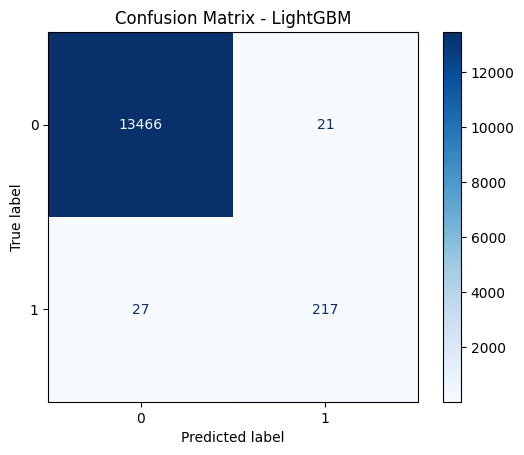

Generating confusion matrix for Catboost...


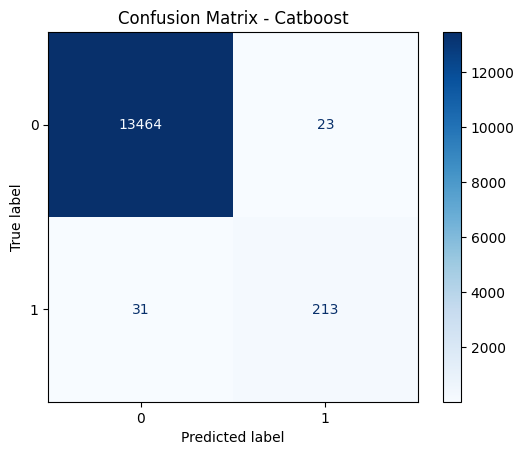

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


best_models = {

    "LightGBM": LGBMClassifier(verbose=0),
    "Catboost": CatBoostClassifier(verbose=0)


}

# Fit the models and plot their confusion matrices
for model_name, model in best_models.items():
    print(f"Generating confusion matrix for {model_name}...")

    # Fit the model
    model.fit(X_train, y_train)

    # Predict the test set
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


### Key takeaway
- We can see that after plotting the confusion matrix the lightgbm performed  slightly better  than  catboost.I will fine tune the lightgbm model
- I will also introduce a better cross validation


### lightgbm

Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67396
           1       0.89      0.90      0.90      1258

    accuracy                           1.00     68654
   macro avg       0.95      0.95      0.95     68654
weighted avg       1.00      1.00      1.00     68654



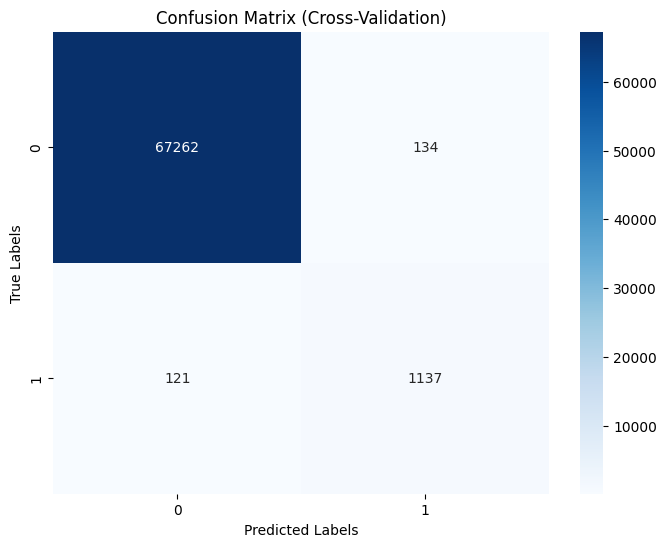

In [35]:

#define parameters
params = {'n_estimators': 550,
          'learning_rate': 0.14516389667333238,
          'max_depth': 6,
          'num_leaves': 112,
          'min_child_samples': 14,
          'class_weight' : 'balanced',
          'subsample': 0.5908780339253514,
          'colsample_bytree': 0.6365287698021516,
          'lambda_l1': 0.0004320454923262998,
          'lambda_l2': 3.65679930085199e-06
}

# Define the LightGBM model
lgbm_model = LGBMClassifier(**params,verbose=-1, random_state=42)

# Cross-validation settings
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize a list to store predictions and true labels for each fold
all_y_true = []
all_y_pred = []

# Cross-validation loop
for train_idx, val_idx in cv.split(X, y):
    # Split data into training and validation sets
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train the model
    lgbm_model.fit(X_tr, y_tr)

    # Predict on the validation set
    y_val_pred = lgbm_model.predict(X_val)

    # Store true and predicted labels
    all_y_true.extend(y_val)
    all_y_pred.extend(y_val_pred)

# Print classification report for the cross-validation results
print("Classification Report (Cross-Validation):")
print(classification_report(all_y_true, all_y_pred))

# Calculate the confusion matrix from cross-validation results
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Cross-Validation)")
plt.show()



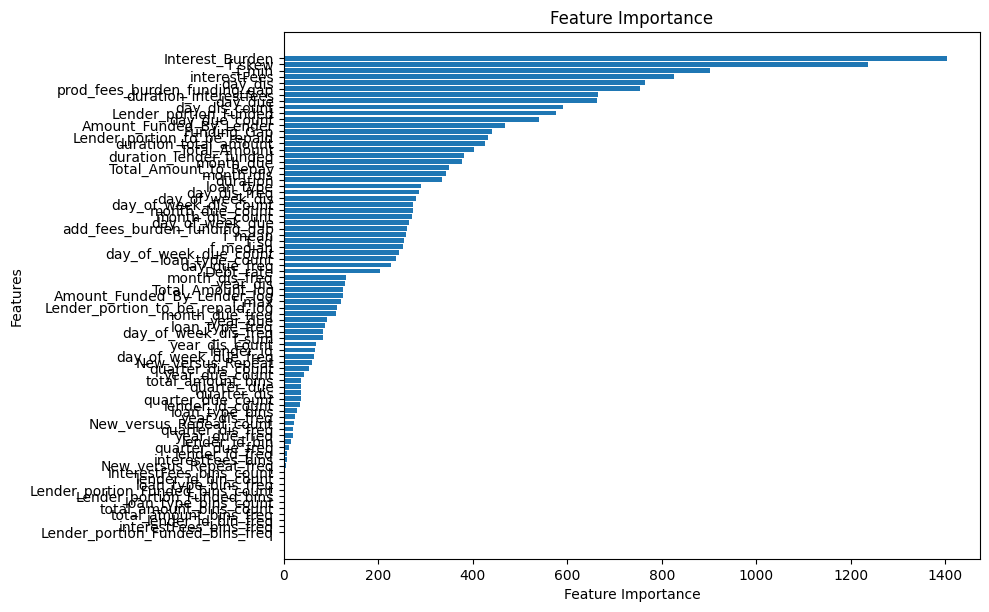

In [37]:
# Calculate feature importances and feature names
importances = lgbm_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances in descending order
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.title('Feature Importance')
plt.show()


In [39]:
# Predict probabilities on the test dataset
test_pred = lgbm_model.predict(test)


In [40]:
submission['target'] = test_pred

In [41]:
submission.head()

,ID,target
0,ID_269404226088267278,0
1,ID_255356300042267278,0
2,ID_257026243764267278,0
3,ID_264617299409267278,0
4,ID_247613296713267278,0


In [42]:
submission['target'].value_counts()

,count
target,
0,17926
1,668


In [43]:
submission.to_csv('submission_lgbm.csv', index=False)